In [ ]:
# importing necessary libraries

import nltk,re,string
from nltk.corpus import stopwords,twitter_samples
import numpy as np
import pickle

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Preprocessing of the tweets data

def process_tweet(tweet):
  stemmer = nltk.PorterStemmer()
  stopwords_english = stopwords.words('english')
  tweet = re.sub(r'\$\w*','',tweet)
  tweet = re.sub(r'^RT[\s]+','',tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*','',tweet)
  tweet = re.sub(r'#','',tweet)
  tokenizer = nltk.TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
    if(word not in stopwords_english and word not in string.punctuation):
      stem_word = stemmer.stem(word)
      tweets_clean.append(stem_word)

  return tweets_clean

learning -> learn <br />
works -> word

 this is the most important part of the whole code <br />
 the reason is our feature set through which we will be training our model on will be build here

In [ ]:
def build_freqs(tweets,ys):
  """
    Build Frequencies.
    Input: a list of tweets
    ys: an m x 1 array with sentiment label of each tweet
    ( either 0 or 1 )
    Output :
    freq : a dictionary mapping each (word,sentiment) pair to its frequency
  """

  yslist = np.squeeze(ys).tolist()
  freqs = {}

  for y, tweet in zip(yslist,tweets):
    for word in process_tweet(tweet):
      pair = (word,y)
      if pair in freqs:
        freqs[pair] += 1
      else:
        freqs[pair] = 1

  return freqs

testing on samples

In [ ]:
tweets = ['i am happy','i am tricked','i am sad','i am tired','i am tired']
ys = [1,0,0,0,0]
res = build_freqs(tweets,ys)
print(res)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}


In [ ]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [ ]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_neutral_weets = twitter_samples.strings('tweets.20150430-223406.json')

In [ ]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

In [ ]:
train_x = train_pos + train_neg
test_x = test_pos + test_neg

combine +ve and -ve results

we r building our y-target variable here

In [ ]:
train_y = np.append(np.ones((len(train_pos),1)),np.zeros((len(train_neg),1)),axis=0)
test_y = np.append(np.ones((len(test_pos),1)),np.zeros((len(test_neg),1)),axis=0)

creating frequency dictionary

In [ ]:
freqs = build_freqs(train_x,train_y)

checking the output

In [ ]:
print("type(freqs) = " + str(type(freqs)))
print("len(freq) = "+ str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freq) = 11307


Testing the function below

In [ ]:
print(' This is an example of a positive tweet: \n', train_x[22])
print('\n This is an example of the processed version of the tweet : \n', process_tweet(train_x[22]))

 This is an example of a positive tweet: 
 @gculloty87 Yeah I suppose she was lol! Chat in a bit just off out x :))

 This is an example of the processed version of the tweet : 
 ['yeah', 'suppos', 'lol', 'chat', 'bit', 'x', ':)']


# **Implementing Logistic Regression from scratch**

The sigmoid function

In [ ]:
def sigmoid(z):
  zz = np.negative(z)
  h = 1 / (1+np.exp(zz))
  return h

**cost function and gradient**

In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    """
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    """

    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)

        # calculate the cost function
        cost = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(), np.log(1-h)))

        # update the weights theta
        theta = theta - (alpha / m) * np.dot(x.transpose(), (h - y))

    cost = float(cost)
    return cost, theta

**Feature Extraction**

In [ ]:
def extract_features(tweet,freqs):
  """
    tweet : a list of words for one tweet
    freqs : a dictionary corresponding to the frequencies of each tuple(word,label)
    output :
    x : a feature vector of dimension (1,3)
  """

  word_l = process_tweet(tweet)
  x = np.zeros((1,3))

  # bias term is set to 1
  x[0,0] = 1

  for word in word_l:
    # increment the word count for the +ve label 1
    x[0,1] += freqs.get((word,1.0),0)

    # increment the word count for the -ve label 0
    x[0,2] += freqs.get((word,0.0),0)

    assert(x.shape == (1,3)) # The assert keyword is a built-in function that tests whether a condition is true or false
  return x

**Testing on training data**

In [ ]:
tmp1 = extract_features(train_x[22],freqs)
print(tmp1)

[[1.000e+00 3.006e+03 1.240e+02]]


 Try to understand what all these three numbers mean.
 Usually we get a dataset with a lot of features/columns, here we just have text data.
 Those three numbers are the feature set that we have build using build_freq() and extract_features() function.
 build_freq() builds a dictionary having words as keys and the number of times they have occurred in corpus as values.
 Extract feature takes in sum of these values for positive and negative words, i.e. tmp[1] and tmp[2]

 How these features will be used to predict in Logistic Regression
# First a hypothesis is build which for our case will be h(x) = b1 + b2 * x1 + b3 * x2
 here b1 = 1, b2 and b3 are determined by cost and gradient function, x1 and x2 are the positive and negative words feature set.

# Training the model

In [ ]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
# these values are predefined (Andrew NG)
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)

<ipython-input-15-e4f85f0674ab>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost = float(cost)


In [ ]:
def predict_tweet(tweet, freqs, theta):
    """
    Input:
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output:
        y_pred: the probability of a tweet being positive or negative
    """
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred

In [ ]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input:
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output:
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """

    # the list for storing predictions
    y_hat = []

    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)

    accuracy = (y_hat == np.squeeze(test_y)).sum() / len(test_x)

    return accuracy

In [ ]:
tmp_accuracy = test_logistic_regression(test_x,test_y,freqs,theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9965


# Predict with ur own sentence

In [ ]:
def pre(sentence):
  yhat = predict_tweet(sentence,freqs,theta)
  if yhat > 0.5:
    return 'Positive sentiment'
  elif yhat == 0:
    return 'Neutral sentiment'
  else:
    return 'Negative sentiment'

In [ ]:
my_tweet = "It is a day."

res = pre(my_tweet)
print(res)

Positive sentiment


In [ ]:
# Enhancing Sentiment Detection with Neutral Classification and Metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities for test data
y_probs = np.array([predict_tweet(tweet, freqs, theta)[0] for tweet in test_x])

# Define thresholds for sentiment
lower_thresh = 0.4
upper_thresh = 0.6

# Predict labels: 0 = Negative, 1 = Neutral, 2 = Positive
y_pred_labels = np.array([
    2 if prob > upper_thresh else (0 if prob < lower_thresh else 1)
    for prob in y_probs
])

# Adjust ground truth for 3-class evaluation: 0 -> 0 (Negative), 1 -> 2 (Positive)
y_true_labels = np.array([2 if y==1 else 0 for y in np.squeeze(test_y)])


In [ ]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0))

Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      0.88      0.94      1000
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.71      0.83      1000

    accuracy                           0.80      2000
   macro avg       0.67      0.53      0.59      2000
weighted avg       1.00      0.80      0.89      2000



In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[882 118   0]
 [  0   0   0]
 [  0 286 714]]


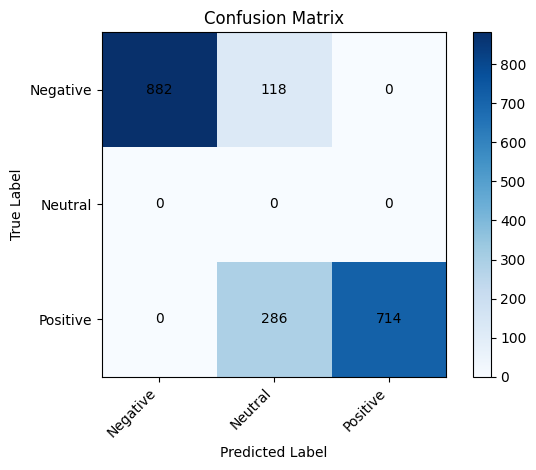

In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title('Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, ['Negative', 'Neutral', 'Positive'])

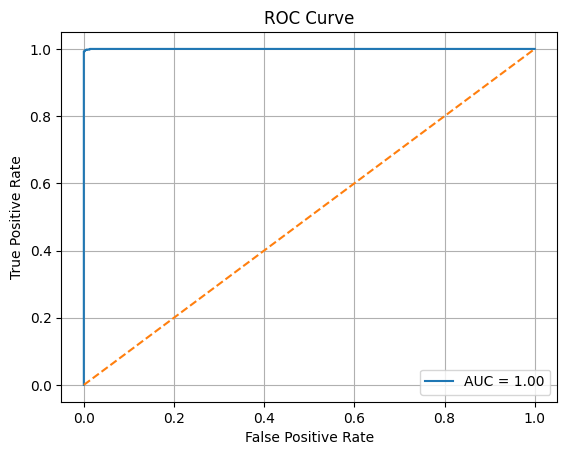

In [ ]:
# ROC Curve (for original binary classification)
fpr, tpr, _ = roc_curve(np.squeeze(test_y), y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

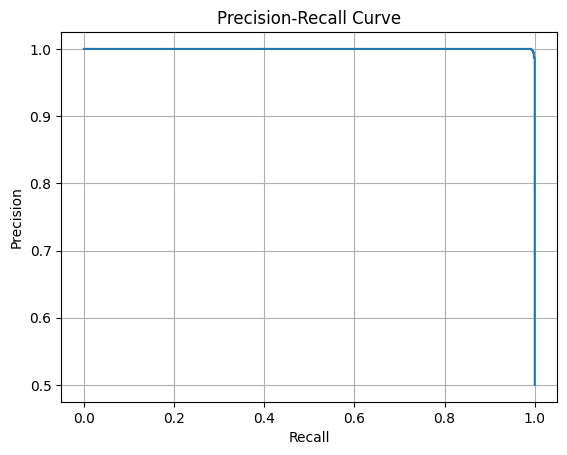

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(np.squeeze(test_y), y_probs)
plt.figure()
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

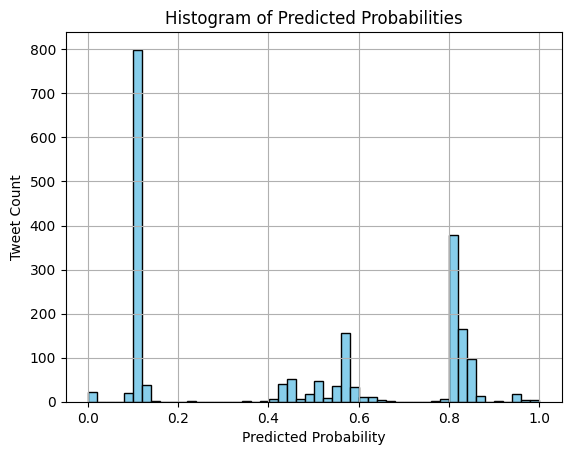

In [ ]:
# Histogram of Predicted Probabilities
plt.figure()
plt.hist(y_probs, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Tweet Count')
plt.grid(True)
plt.show()